In [1]:
import torch
import random
import gc
import dataclasses
import tqdm
import os

import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForCausalLM

def load_model_and_tokenizer(gpu_num, model_name="meta-llama/Llama-2-7b-chat-hf"):
    device = torch.device(f"cuda:{gpu_num}")
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        #cache_dir="/data2/sjeromeh/cache/pretrained_models",
        dtype=torch.bfloat16,
    ).to(device)
    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        #cache_dir="/data2/sjeromeh/cache/pretrained_models"
    )
    tokenizer.pad_token_id = tokenizer.eos_token_id
    model.eval()
    return model, tokenizer


def clear_hooks(input_hooks):
    for hook in input_hooks:
        hook.remove()
    input_hooks = []
    gc.collect()

In [2]:
!pip install huggingface_hub
from huggingface_hub import login
# either argue your huggingface token, or put it in a file
# named "your_token.txt" in the working directory
with open("your_token.txt", "r") as f:
    your_token = f.read().strip()
login(token=your_token)


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


# Load model and tokenizer

In [3]:
# Choose model here
# Options are keys of model_names dict below
model_alias = "llama-3-instruct"

model_names = {
    "pythia-7b": "EleutherAI/pythia-6.9b",
    "llama-3-1": "meta-llama/Llama-3.1-8B",
    "llama-3-instruct":"meta-llama/Meta-Llama-3-8B-Instruct",
    "llama-2-7b-chat": "meta-llama/Llama-2-7b-chat-hf",
}
space_token = {
    "pythia-7b": "Ġ",
    "llama-3-1": "Ġ",
    "llama-2-7b-chat": "▁",
    "llama-3-instruct":" ",
}[model_alias]
model_name = model_names[model_alias]
model, tokenizer = load_model_and_tokenizer(0, model_name=model_name)
device = model.device

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

# Load data

In [4]:
countries_df = pd.read_csv("data/countries.csv")
names_df = pd.read_csv("data/names.csv", index_col=0)

countries_to_capitals = countries_df.set_index("country")["capital"].to_dict()
names = names_df["name"].tolist()

# Keep only single token countries and names
countries_to_capitals = {k: v for k, v in countries_to_capitals.items() if len(tokenizer.encode(f" {k}", add_special_tokens=False)) == 1}
names = [n for n in names if len(tokenizer.encode(n, add_special_tokens=False)) == 1]

print(f"Number of countries: {len(countries_to_capitals)}, Sample: {list(countries_to_capitals.items())[:5]}")
print(f"Number of names: {len(names)}, Sample: {names[:5]}")

Number of countries: 125, Sample: [('Afghanistan', 'Kabul'), ('Albania', 'Tirana'), ('Algeria', 'Algiers'), ('Angola', 'Luanda'), ('Argentina', 'Buenos Aires')]
Number of names: 59, Sample: ['Michael', 'James', 'John', 'Robert', 'David']


# Prompt generation

In [5]:
@dataclasses.dataclass(frozen=True)
class Prompt:
    context: str
    questions: list[str]
    answers: list[str]
    names: list[str]
    countries: list[str]


def generate_prompt_pair(
    num_entities,
    all_names=names,
    all_countries=list(countries_to_capitals.keys()),
    parot=False,
):
    """
    Args:
        parot: bool
            if true, will simplify the problem such that the answer
            merely requires regurgitating the already specified city.
            Otherwise, model needs to associate the countries with
            their capitals.
    """
    cs = random.sample(all_countries, num_entities*2)
    ns = random.sample(all_names, num_entities*2)

    cs_1 = cs[:num_entities]
    ns_1 = ns[:num_entities]
    cs_2 = cs[num_entities:]
    ns_2 = ns[num_entities:]

    if parot:
        target_answers = [c for c in cs_1]
        source_answers = [c for c in cs_2]
        es_1 = [f"{n} lives in {c}." for c, n in zip(target_answers, ns_1)]
        es_2 = [f"{n} lives in {c}." for c, n in zip(source_answers, ns_2)]
        target_questions = [f"Question: What country does {n} live in?" for n in ns_1]
        source_questions = [f"Question: What country does {n} live in?" for n in ns_2]
    else:
        es_1 = [f"{n} lives in the capital city of {c}." for c, n in zip(cs_1, ns_1)]
        es_2 = [f"{n} lives in the capital city of {c}." for c, n in zip(cs_2, ns_2)]
        target_answers = [countries_to_capitals[c] for c in cs_1]
        source_answers = [countries_to_capitals[c] for c in cs_2]
        target_questions = [f"Question: Which city does {n} live in?" for n in ns_1]
        source_questions = [f"Question: Which city does {n} live in?" for n in ns_2]
    target_context =  f"Answer the question based on the context below. Keep the answer short.\n\nContext: {' '.join(es_1)}"
    source_context =  f"Answer the question based on the context below. Keep the answer short.\n\nContext: {' '.join(es_2)}"
    return (Prompt(
        context=target_context,
        questions=target_questions,
        answers=target_answers,
        names=ns_1,
        countries=cs_1,
    ), Prompt(
        context=source_context,
        questions=source_questions,
        answers=source_answers,
        names=ns_2,
        countries=cs_2,
    ))


In [11]:
parot = False # if true, task will be to predicted the provided attributes. if false, predict cities from attributes
target_prompt, source_prompt = generate_prompt_pair(2, parot=parot)
print("Target:", target_prompt.context)
print("Questions:", target_prompt.questions)
print("Answers:", target_prompt.answers)
print()
print("Source:", source_prompt.context)
print("Questions:", source_prompt.questions)
print("Answers", source_prompt.answers)

Target: Answer the question based on the context below. Keep the answer short.

Context: Sarah lives in the capital city of Jamaica. John lives in the capital city of Guam.
Questions: ['Question: Which city does Sarah live in?', 'Question: Which city does John live in?']
Answers: ['Kingston', 'Hagåtña']

Source: Answer the question based on the context below. Keep the answer short.

Context: Joseph lives in the capital city of Argentina. Jacob lives in the capital city of Nicaragua.
Questions: ['Question: Which city does Joseph live in?', 'Question: Which city does Jacob live in?']
Answers ['Buenos Aires', 'Managua']


# Patching experiment

In [12]:
def save_outputs(layer: int, save_map: dict):
    """Hook function for saving the output of a model component"""
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            proj_output = output[0]
        else:
            proj_output = output
        save_map[layer] = proj_output.clone()
        return output
    return hook_fn


def save_hidden_states(ids, model):
    """Save the hidden states of a model. Returns model output and a (num_layers,num_tokens,hidden_size) tensor of hidden states."""
    hooks = []
    hidden_states = {}
    model_layers = model.gpt_neox.layers if "pythia" in model_name else model.model.layers
    for layer,model_layer in enumerate(model_layers):
        hidden_state_hook_handle = model_layer.register_forward_hook(
            save_outputs(layer, hidden_states)
        )
        hooks.append(hidden_state_hook_handle)
    with torch.no_grad():
        out = model(
            ids,
            attention_mask=torch.ones_like(ids),
        )
    clear_hooks(hooks)
    hidden_states_tensor = torch.stack([hidden_states[i] for i in range(len(hidden_states))], dim=0).squeeze(1)
    return out, hidden_states_tensor


def replace_outputs(layer: int, target_layers: list[int], target_position: int, original_hidden_states: dict, modified_hidden_states: dict):
    """Hook function for replacing hidden states of a target layer at a target position with the hidden states from a modified prompt."""
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            proj_output = output[0]
        else:
            proj_output = output

        unsqueeze = len(proj_output.shape)>2
        proj_output = proj_output.squeeze()
        #proj_output = original_hidden_states[layer].clone()
        if layer in target_layers:
            proj_output[target_position:target_position+2,:] = modified_hidden_states[layer,target_position:target_position+2,:].clone()
        if unsqueeze: proj_output = proj_output[None]

        if isinstance(proj_output, tuple):
            return (proj_output,) + output[1:]
        else:
            return proj_output
    return hook_fn


def replace_hidden_states(ids, model, target_position, original_hidden_states, modified_hidden_states):
    """Replace the hidden states of a model. Returns model output."""
    hooks = []
    model_layers = model.gpt_neox.layers if "pythia" in model_name else model.model.layers
    for layer,model_layer in enumerate(model_layers):
        hidden_state_hook_handle = model_layer.register_forward_hook(
            replace_outputs(
                layer,
                list(range(len(model_layers))),
                target_position,
                original_hidden_states,
                modified_hidden_states
            )
        )
        hooks.append(hidden_state_hook_handle)
    with torch.no_grad():
        try:
            out = model(
                ids,
                attention_mask=torch.ones_like(ids),
            )
        except:
            clear_hooks(hooks)
            assert False
    clear_hooks(hooks)
    return out

In [13]:
def manual_decode(token_ids, tokenizer):
    decoded = []
    for tok in token_ids:
        decoded.append(tokenizer.decode(tok))
    return decoded
        
def batch_manual_decode(token_ids, tokenizer):
    all_decoded = []
    for samp in range(len(token_ids)):
        decoded = manual_decode(token_ids[samp], tokenizer)
        all_decoded.append(decoded)
    return all_decoded

In [14]:
debug = True
rows = []
nruns = 100 if not debug else 5
for run in tqdm.tqdm(range(nruns)):
    
    mp, ap = generate_prompt_pair(2)
    for query_entity_idx in range(4):
        
        query_entities = mp.names + ap.names
        questions = mp.questions + ap.questions
        if parot:
            main_prompt = mp.context + "\n" + questions[query_entity_idx] + f"\nAnswer: {query_entities[query_entity_idx]} lives in"
            alt_prompt = ap.context + "\n" + questions[query_entity_idx] + f"\nAnswer: {query_entities[query_entity_idx]} lives in"
        else:
            main_prompt = mp.context + "\n" + questions[query_entity_idx] + f"\nAnswer: {query_entities[query_entity_idx]} lives in the city of"
            alt_prompt = ap.context + "\n" + questions[query_entity_idx] + f"\nAnswer: {query_entities[query_entity_idx]} lives in the city of"

        main_prompt_tokens = tokenizer(main_prompt, return_tensors="pt").to(device)
        alt_prompt_tokens = tokenizer(alt_prompt, return_tensors="pt").to(device)
        main_ids = main_prompt_tokens["input_ids"]
        alt_ids = alt_prompt_tokens["input_ids"]

        #main_decoded_tokens = tokenizer.convert_ids_to_tokens(main_prompt_tokens["input_ids"][0])
        main_decoded_tokens = manual_decode(main_prompt_tokens["input_ids"][0], tokenizer)
        main_n1_index = main_decoded_tokens.index(f"{space_token}{mp.names[0]}")
        main_n2_index = main_decoded_tokens.index(f"{space_token}{mp.names[1]}")
        main_c1_index = main_decoded_tokens.index(f"{space_token}{mp.countries[0]}")
        main_c2_index = main_decoded_tokens.index(f"{space_token}{mp.countries[1]}")
        
        #alt_decoded_tokens = tokenizer.convert_ids_to_tokens(alt_prompt_tokens["input_ids"][0])
        alt_decoded_tokens = manual_decode(alt_prompt_tokens["input_ids"][0], tokenizer)
        alt_n1_index = alt_decoded_tokens.index(f"{space_token}{ap.names[0]}")
        alt_n2_index = alt_decoded_tokens.index(f"{space_token}{ap.names[1]}")
        alt_c1_index = alt_decoded_tokens.index(f"{space_token}{ap.countries[0]}")
        alt_c2_index = alt_decoded_tokens.index(f"{space_token}{ap.countries[1]}")
        if not (main_n1_index == alt_n1_index and main_n2_index == alt_n2_index and main_c1_index == alt_c1_index and main_c2_index == alt_c2_index):
            print("Mismatch in indices")
            continue

        main_a1_id = tokenizer(" " + mp.answers[0], add_special_tokens=False)["input_ids"][0]
        main_a2_id = tokenizer(" " + mp.answers[1], add_special_tokens=False)["input_ids"][0]
        alt_a1_id = tokenizer(" " + ap.answers[0], add_special_tokens=False)["input_ids"][0]
        alt_a2_id = tokenizer(" " + ap.answers[1], add_special_tokens=False)["input_ids"][0]

        # Get hidden states
        with torch.no_grad():
            main_out, main_hidden_states = save_hidden_states(main_ids, model)
            alt_out, alt_hidden_states = save_hidden_states(alt_ids, model)

        for modify_index in [main_n1_index, main_n2_index, main_c1_index, main_c2_index]:

            # Modify hidden states by replacing with alt_hidden_states
            modified_out = replace_hidden_states(main_ids, model, modify_index, main_hidden_states, alt_hidden_states)
            modified_log_probs = F.log_softmax(modified_out.logits[0,-1,:], dim=-1)
            rows += [
                {
                    "run": run,
                    "query_name": ["e0", "e1", "e0'", "e1'"][query_entity_idx],
                    "attribute": ["a0", "a1", "a0'", "a1'"][i],
                    "swap_type": "entity" if modify_index in [main_n1_index, main_n2_index] else "attribute",
                    "swap_index": 0 if modify_index in [main_n1_index, main_c1_index] else 1,
                    "log_prob": modified_log_probs[a_id].item(),
                } for i, a_id in enumerate([main_a1_id, main_a2_id, alt_a1_id, alt_a2_id])
            ]

    df = pd.DataFrame(rows)
    if not os.path.exists(f"results/table-1/{model_alias}"):
        os.makedirs(f"results/table-1/{model_alias}")
    df.to_csv(f"results/table-1/{model_alias}/factorizability.csv", index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.71s/it]


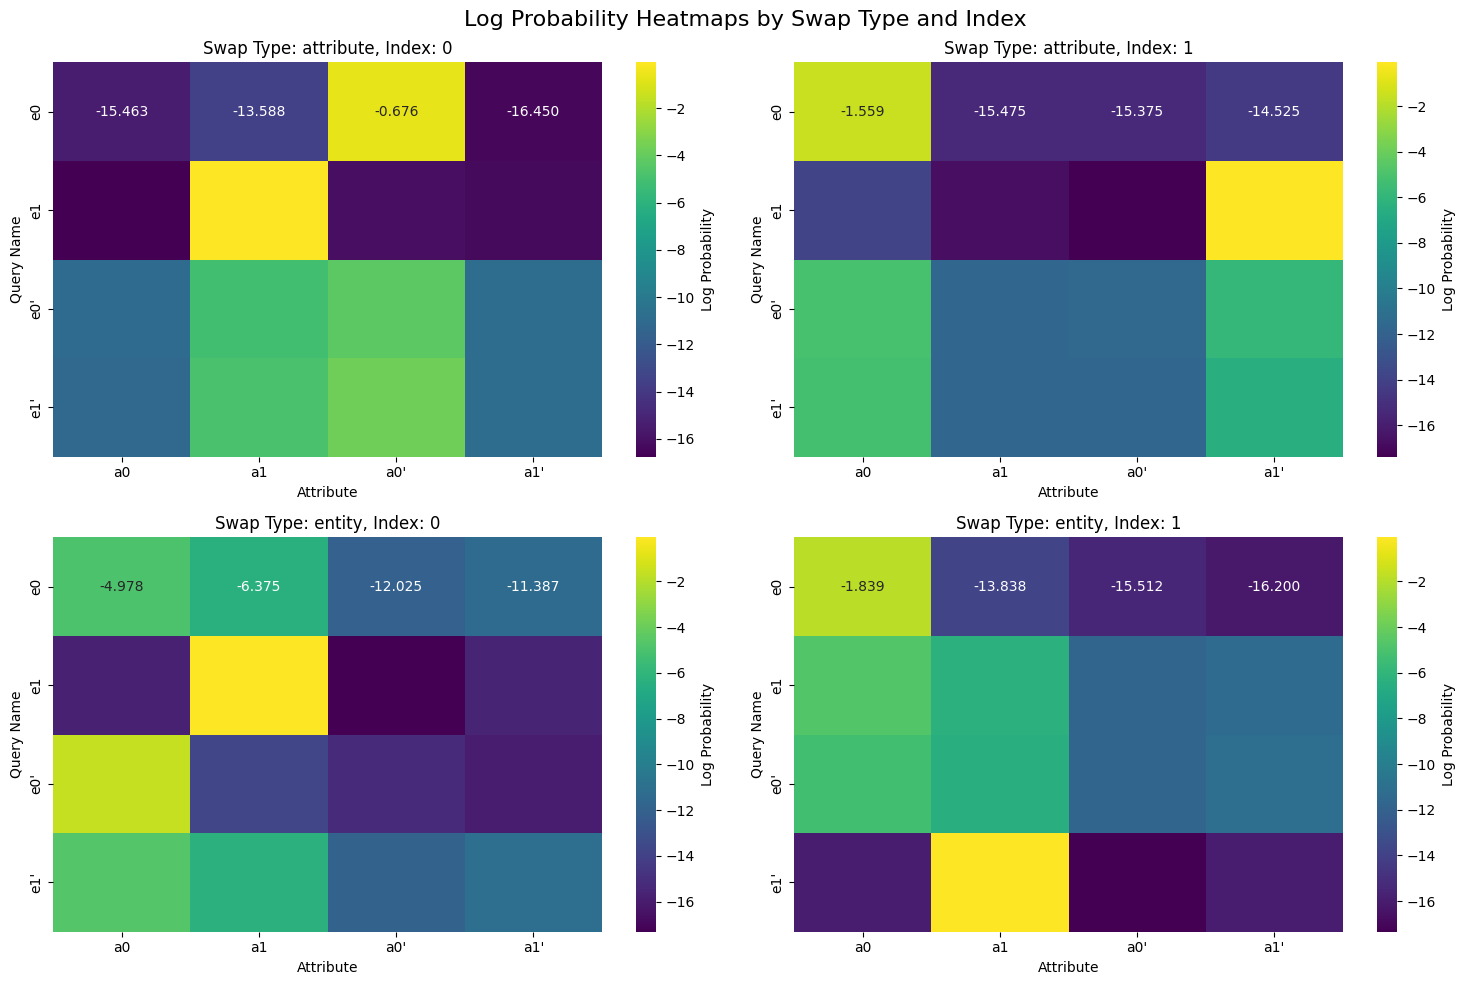

In [15]:
df = pd.read_csv(f"results/table-1/{model_alias}/factorizability.csv")
accuracy_df = df.groupby(["query_name", "attribute", "swap_type", "swap_index"]).mean().reset_index()

# Create subplots for each combination of swap_type and swap_index
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Log Probability Heatmaps by Swap Type and Index', fontsize=16)

# Define the order for consistent plotting
attribute_order = ['a0', 'a1', "a0'", "a1'"]
query_order = ['e0', 'e1', "e0'", "e1'"]

# Get unique combinations of swap_type and swap_index
swap_combinations = accuracy_df[['swap_type', 'swap_index']].drop_duplicates().sort_values(['swap_type', 'swap_index'])

for idx, (_, row) in enumerate(swap_combinations.iterrows()):
    swap_type = row['swap_type']
    swap_index = row['swap_index']
    
    # Filter data for this combination
    subset = accuracy_df[(accuracy_df['swap_type'] == swap_type) & (accuracy_df['swap_index'] == swap_index)]
    
    # Create pivot table for heatmap
    pivot_data = subset.pivot(index='query_name', columns='attribute', values='log_prob')
    
    # Reorder according to specified order
    pivot_data = pivot_data.reindex(index=query_order, columns=attribute_order)
    
    # Determine subplot position
    row_idx = idx // 2
    col_idx = idx % 2
    
    # Create heatmap
    sns.heatmap(pivot_data, 
                annot=True, 
                fmt='.3f', 
                cmap='viridis',
                ax=axes[row_idx, col_idx],
                cbar_kws={'label': 'Log Probability'})
    
    axes[row_idx, col_idx].set_title(f'Swap Type: {swap_type}, Index: {swap_index}')
    axes[row_idx, col_idx].set_xlabel('Attribute')
    axes[row_idx, col_idx].set_ylabel('Query Name')

plt.tight_layout()
plt.show()


#### Additivity replication

In [41]:
def modify_outputs(
    layer: int,
    target_layers: list[int],
    pos1: int,
    pos2: int,
    original_hidden_states: torch.tensor,
    delta: torch.tensor,
    save_hidden_states: dict,
    alt_pos1: int=None,
    alt_pos2: int=None,
    alt_delta: torch.tensor=None,
):
    """Hook function for adding/subtracting a delta to the hidden states of a target layer at a target position."""
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            proj_output = output[0]
        else:
            proj_output = output

        if layer in target_layers:
            og_output = original_hidden_states[layer].clone()
            unsqueeze = len(proj_output.shape)>2
            proj_output = proj_output.squeeze()
            
            # Intervene
            proj_output[pos1:pos1+2,:] = og_output[pos1:pos1+2,:] + delta[layer,:].clone()
            proj_output[pos2:pos2+2,:] = og_output[pos2:pos2+2,:] - delta[layer,:].clone()
            
            # Intervene again
            if alt_pos1 is not None:
                proj_output[alt_pos1:alt_pos1+2,:] = og_output[alt_pos1:alt_pos1+2,:] + alt_delta[layer,:].clone()
                proj_output[alt_pos2:alt_pos2+2,:] = og_output[alt_pos2:alt_pos2+2,:] - alt_delta[layer,:].clone()
                
            save_hidden_states[layer] = proj_output.clone()
            if unsqueeze: proj_output = proj_output[None]
        
        if isinstance(proj_output, tuple):
            return (proj_output,) + output[1:]
        else:
            return proj_output
    return hook_fn


def modify_hidden_states(
    ids,
    model,
    e0_pos,
    e1_pos,
    a0_pos,
    a1_pos,
    original_hidden_states,
    entity_delta,
    attribute_delta,
    condition,
):
    """Modify the hidden states of a model by adding a delta to the original hidden states. Returns model output."""
    hooks = []
    hidden_states = {}
    model_layers = model.gpt_neox.layers if "pythia" in model_name else model.model.layers
    for layer,model_layer in enumerate(model_layers):
        if "both" in condition:
            hidden_state_hook_handle = model_layer.register_forward_hook(
                modify_outputs(
                    layer=layer,
                    target_layers=list(range(len(model_layers))),
                    pos1=a0_pos,
                    pos2=a1_pos,
                    alt_pos1=e0_pos,
                    alt_pos2=e1_pos,
                    original_hidden_states=original_hidden_states,
                    delta=attribute_delta,
                    alt_delta=entity_delta,
                    save_hidden_states=hidden_states,
                )
            )
            hooks.append(hidden_state_hook_handle)
        elif "attribute" in condition:
            hidden_state_hook_handle = model_layer.register_forward_hook(
                modify_outputs(
                    layer=layer,
                    target_layers=list(range(len(model_layers))),
                    pos1=a0_pos,
                    pos2=a1_pos,
                    original_hidden_states=original_hidden_states,
                    delta=attribute_delta,
                    save_hidden_states=hidden_states,
                )
            )
            hooks.append(hidden_state_hook_handle)
        elif "entity" in condition:
            hidden_state_hook_handle = model_layer.register_forward_hook(
                modify_outputs(
                    layer=layer,
                    target_layers=list(range(len(model_layers))),
                    pos1=e0_pos,
                    pos2=e1_pos,
                    original_hidden_states=original_hidden_states,
                    delta=entity_delta,
                    save_hidden_states=hidden_states,
                )
            )
            hooks.append(hidden_state_hook_handle)
        else:
            raise ValueError(f"Invalid condition: {condition}")
    with torch.no_grad():
        out = model(
            ids,
            attention_mask=torch.ones_like(ids),
        )
    hidden_states_tensor = torch.stack([hidden_states[i] for i in range(len(hidden_states))], dim=0).squeeze(1)
    clear_hooks(hooks)
    return out, hidden_states_tensor

In [53]:
debug = False
# Allocate 'train' and 'test' names and countries for calculating means
train_names = names[:len(names)//2]
test_names = names[len(names)//2:]
train_countries = list(countries_to_capitals.keys())[:len(countries_to_capitals)//2]
test_countries = list(countries_to_capitals.keys())[len(countries_to_capitals)//2:]

# Calculate mean differences
num_runs = 500
attribute_deltas = []
entity_deltas = []

it = tqdm.tqdm(range(5)) if debug else tqdm.tqdm(range(num_runs))
for _ in it:

    mp, ap = generate_prompt_pair(2, train_names, train_countries, parot=parot)

    for query_entity_idx in range(2):

        if parot:
            main_prompt = mp.context + "\n" + mp.questions[query_entity_idx] + f"\nAnswer: {mp.names[query_entity_idx]} lives in"
            alt_prompt = ap.context + "\n" + ap.questions[query_entity_idx] + f"\nAnswer: {ap.names[query_entity_idx]} lives in"
        else:
            main_prompt = mp.context + "\n" + mp.questions[query_entity_idx] + f"\nAnswer: {mp.names[query_entity_idx]} lives in the city of"
            alt_prompt = ap.context + "\n" + ap.questions[query_entity_idx] + f"\nAnswer: {ap.names[query_entity_idx]} lives in the city of"
        
        main_prompt_tokens = tokenizer(main_prompt, return_tensors="pt").to(device)
        alt_prompt_tokens = tokenizer(alt_prompt, return_tensors="pt").to(device)
        main_ids = main_prompt_tokens["input_ids"]
        alt_ids = alt_prompt_tokens["input_ids"]

        main_decoded_tokens = manual_decode(main_prompt_tokens["input_ids"][0], tokenizer)
        alt_decoded_tokens =  manual_decode(alt_prompt_tokens["input_ids"][0], tokenizer)
        main_n1_index = main_decoded_tokens.index(f"{space_token}{mp.names[0]}")
        main_n2_index = main_decoded_tokens.index(f"{space_token}{mp.names[1]}")
        main_c1_index = main_decoded_tokens.index(f"{space_token}{mp.countries[0]}")
        main_c2_index = main_decoded_tokens.index(f"{space_token}{mp.countries[1]}")
        alt_n1_index = alt_decoded_tokens.index(f"{space_token}{ap.names[0]}")
        alt_n2_index = alt_decoded_tokens.index(f"{space_token}{ap.names[1]}")
        alt_c1_index = alt_decoded_tokens.index(f"{space_token}{ap.countries[0]}")
        alt_c2_index = alt_decoded_tokens.index(f"{space_token}{ap.countries[1]}")
        if not (main_n1_index == alt_n1_index and main_n2_index == alt_n2_index and main_c1_index == alt_c1_index and main_c2_index == alt_c2_index):
            print("Mismatch in indices")
            continue

        # Get hidden states
        with torch.no_grad():
            main_out, main_hidden_states = save_hidden_states(main_ids, model)
            alt_out, alt_hidden_states = save_hidden_states(alt_ids, model)

        attribute_deltas.append(main_hidden_states[:, main_c2_index:main_c2_index+2, :] - alt_hidden_states[:, alt_c1_index:alt_c1_index+2, :])
        entity_deltas.append(   main_hidden_states[:, main_n2_index:main_n2_index+2, :] - alt_hidden_states[:, alt_n1_index:alt_n1_index+2, :])

attribute_deltas = torch.stack(attribute_deltas, dim=0).mean(dim=0)
entity_deltas = torch.stack(entity_deltas, dim=0).mean(dim=0)
random_entity_deltas = torch.randn_like(entity_deltas) * entity_deltas.std()
random_attribute_deltas = torch.randn_like(attribute_deltas) * attribute_deltas.std()


# Calculate effect of mean interventions
num_runs = 5 if debug else 100
rows = []
all_original_attribute_hidden_states = []
all_original_entity_hidden_states = []
all_intervened_attribute_hidden_states = []
all_intervened_entity_hidden_states = []
all_modified_attribute_hidden_states = []
all_modified_entity_hidden_states = []
for run in tqdm.tqdm(range(num_runs)):

    p, _ = generate_prompt_pair(2, test_names, test_countries, parot=parot)

    for query_entity_idx in range(2):

        if parot:
            prompt = p.context + "\n" + p.questions[query_entity_idx] + f"\nAnswer: {p.names[query_entity_idx]} lives in"
        else:
            prompt = p.context + "\n" + p.questions[query_entity_idx] + f"\nAnswer: {p.names[query_entity_idx]} lives in the city of"

        # Get tokens
        prompt_tokens = tokenizer(prompt, return_tensors="pt").to(device)
        ids = prompt_tokens["input_ids"]
        a1_id = tokenizer(" " + p.answers[0], add_special_tokens=False)["input_ids"][0]
        a2_id = tokenizer(" " + p.answers[1], add_special_tokens=False)["input_ids"][0]

        # Get token positions of entities and attributes
        decoded_tokens = manual_decode(ids[0], tokenizer)
        e0_pos = decoded_tokens.index(f"{space_token}{p.names[0]}")
        e1_pos = decoded_tokens.index(f"{space_token}{p.names[1]}")
        a0_pos = decoded_tokens.index(f"{space_token}{p.countries[0]}")
        a1_pos = decoded_tokens.index(f"{space_token}{p.countries[1]}")

        # control condition
        with torch.no_grad():
            out, original_hidden_states = save_hidden_states(ids, model)
            logprobs = F.log_softmax(out.logits[0, -1], dim=-1)
        rows.append({
            "run_id": run,
            "condition": "control",
            "query_entity_idx": query_entity_idx,
            "max_logprob_token": tokenizer.decode(logprobs.argmax().item()),
            "max_logprob": logprobs.max().item(),
            "a1_token": tokenizer.decode(a1_id),
            "a1_logprob": logprobs[a1_id].item(),
            "a2_token": tokenizer.decode(a2_id),
            "a2_logprob": logprobs[a2_id].item(),
            "correct_answer": "a1" if query_entity_idx == 0 else "a2",
        })
        all_original_attribute_hidden_states.append(original_hidden_states[:, [a0_pos, a0_pos+1, a1_pos, a1_pos+1], :].cpu())
        all_original_entity_hidden_states.append(   original_hidden_states[:, [e0_pos, e0_pos+1, e1_pos, e1_pos+1], :].cpu())

        # Modified conditions
        for condition in ["attribute", "entity", "both", "random-attribute", "random-entity", "random-both"]:
            if "random" in condition:
                out, intervened_hidden_states = modify_hidden_states(
                    ids=ids,
                    model=model,
                    e0_pos=e0_pos,
                    e1_pos=e1_pos,
                    a0_pos=a0_pos,
                    a1_pos=a1_pos,
                    original_hidden_states=original_hidden_states,
                    entity_delta=random_entity_deltas,
                    attribute_delta=random_attribute_deltas,
                    condition=condition,
                )
            else:
                out, intervened_hidden_states = modify_hidden_states(
                    ids=ids,
                    model=model,
                    e0_pos=e0_pos,
                    e1_pos=e1_pos,
                    a0_pos=a0_pos,
                    a1_pos=a1_pos,
                    original_hidden_states=original_hidden_states,
                    entity_delta=entity_deltas,
                    attribute_delta=attribute_deltas,
                    condition=condition,
                )
            logprobs = F.log_softmax(out.logits[0, -1], dim=-1)
            rows.append({
                "run_id": run,
                "condition": condition,
                "query_entity_idx": query_entity_idx,
                "max_logprob_token": tokenizer.decode(logprobs.argmax().item()),
                "max_logprob": logprobs.max().item(),
                "a1_token": tokenizer.decode(a1_id),
                "a1_logprob": logprobs[a1_id].item(),
                "a2_token": tokenizer.decode(a2_id),
                "a2_logprob": logprobs[a2_id].item(),
                "correct_answer": "a1" if query_entity_idx == 0 else "a2",
            })

            if "random" not in condition and "both" not in condition:
                if "attribute" in condition:
                    all_intervened_attribute_hidden_states.append(intervened_hidden_states[:, [a0_pos, a0_pos+1, a1_pos, a1_pos+1], :].cpu())
                else:
                    all_intervened_entity_hidden_states.append(intervened_hidden_states[:, [e0_pos, e0_pos+1, e1_pos, e1_pos+1], :].cpu())

                if "attribute" in condition:
                    attributes = p.countries[::-1]
                    entities = p.names
                else:
                    attributes = p.countries
                    entities = p.names[::-1]
                if parot:
                    modified_prompt = f"Answer the question based on the context below. Keep the answer short.\n\nContext: {entities[0]} lives in {attributes[0]}. {entities[1]} lives in {attributes[1]}.\nQuestion: Where does {p.names[query_entity_idx]} live?\nAnswer: {p.names[query_entity_idx]} lives in"
                else:
                    modified_prompt = f"Answer the question based on the context below. Keep the answer short.\n\nContext: {entities[0]} lives in the capital city of {attributes[0]}. {entities[1]} lives in the capital city of {attributes[1]}.\nQuestion: Which city does {p.names[query_entity_idx]} live in?\nAnswer: {p.names[query_entity_idx]} lives in the city of"
                modified_prompt_tokens = tokenizer(modified_prompt, return_tensors="pt").to(device)
                modified_ids = modified_prompt_tokens["input_ids"]
                with torch.no_grad():
                    _, modified_hidden_states = save_hidden_states(modified_ids, model)
                if "attribute" in condition:
                    all_modified_attribute_hidden_states.append(modified_hidden_states[:, [a0_pos, a0_pos+1, a1_pos, a1_pos+1], :].cpu())
                else:
                    all_modified_entity_hidden_states.append(modified_hidden_states[:, [e0_pos, e0_pos+1, e1_pos, e1_pos+1], :].cpu())

df = pd.DataFrame(rows)
df.to_csv(f"results/table-1/{model_alias}/mean_interventions.csv", index=False)
        
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:24<00:00,  4.45s/it]


In [54]:
df = pd.read_csv(f"results/table-1/{model_alias}/mean_interventions.csv")

def row_is_correct(row):
    return (row["correct_answer"] == "a1" and row["a1_logprob"] > row["a2_logprob"]) or (row["correct_answer"] == "a2" and row["a2_logprob"] > row["a1_logprob"])

for condition, cdf in df.groupby("condition"):
    accuracy = len([1 for _, row in cdf.iterrows() if row_is_correct(row)]) / len(cdf)
    print(f"{condition}: {accuracy}")

attribute: 0.21
both: 1.0
control: 1.0
entity: 0.715
random-attribute: 0.755
random-both: 0.565
random-entity: 0.775


In [55]:
len(all_original_attribute_hidden_states)

200

In [56]:
all_original_attribute_hidden_states_matrix =   torch.stack(all_original_attribute_hidden_states)
all_original_entity_hidden_states_matrix =      torch.stack(all_original_entity_hidden_states)
all_intervened_attribute_hidden_states_matrix = torch.stack(all_intervened_attribute_hidden_states)
all_intervened_entity_hidden_states_matrix =    torch.stack(all_intervened_entity_hidden_states)
all_modified_attribute_hidden_states_matrix =   torch.stack(all_modified_attribute_hidden_states)
all_modified_entity_hidden_states_matrix =      torch.stack(all_modified_entity_hidden_states)

print(all_original_attribute_hidden_states_matrix.shape)
print(all_original_entity_hidden_states_matrix.shape)
print(all_intervened_attribute_hidden_states_matrix.shape)
print(all_intervened_entity_hidden_states_matrix.shape)
print(all_modified_attribute_hidden_states_matrix.shape)
print(all_modified_entity_hidden_states_matrix.shape)

torch.Size([200, 32, 4, 4096])
torch.Size([200, 32, 4, 4096])
torch.Size([200, 32, 4, 4096])
torch.Size([400, 32, 4, 4096])
torch.Size([200, 32, 4, 4096])
torch.Size([400, 32, 4, 4096])


In [150]:
def filter_by_layer_and_position(natty_hstates, intrv_hstates, layer=None, pos=None):
    d = natty_hstates.shape[-1]
    if layer is not None:
        natty_hstates = natty_hstates[:,layer]
        intrv_hstates = intrv_hstates[:,layer]
    if pos is None:
        natty_states = [natty_hstates[i].reshape(-1,d) for i in range(len(natty_hstates))]
        intrv_states = [intrv_hstates[i].reshape(-1,d) for i in range(len(natty_hstates))]
    else:
        natty_states = [natty_hstates[i][pos].reshape(-1,d) for i in range(len(natty_hstates))]
        intrv_states = [intrv_hstates[i][pos].reshape(-1,d) for i in range(len(natty_hstates))]
    natty_states = torch.vstack(natty_states)
    intrv_states = torch.vstack(intrv_states)
    return natty_states, intrv_states

In [151]:
all_intervened_attribute_hidden_states_matrix.shape

torch.Size([200, 32, 4, 4096])


Layer: 9
Natty PCA
natty: torch.Size([800, 4096])
intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.2014, 0.1321, 0.1213, 0.0854, 0.0671])
X: 0 Y: 1
Expl Vars: tensor(0.2014) tensor(0.1321)


/home/grantsrb/src/binding-vectors/divergence_utilities.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_vecs = torch.tensor(vecs[:len(natty_states)])
/home/grantsrb/src/binding-vectors/divergence_utilities.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  intrv_vecs = torch.tensor(vecs[len(natty_states):])
/home/grantsrb/src/binding-vectors/divergence_utilities.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float()
/home/grantsrb/src/binding-vectors/divergence_uti

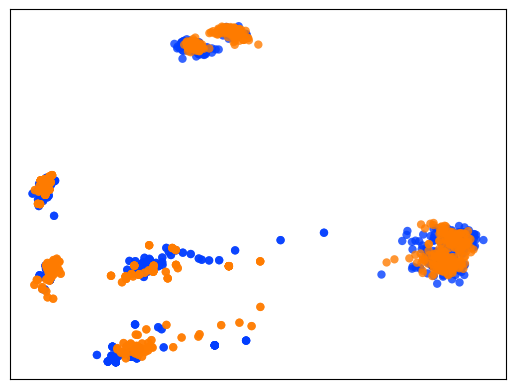

MSE: 1.66754
EMD: 559.85376
BaseEMD: 0.0

Layer: 10
Natty PCA
natty: torch.Size([800, 4096])
intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.2049, 0.1381, 0.1268, 0.0871, 0.0686])
X: 0 Y: 1
Expl Vars: tensor(0.2049) tensor(0.1381)


/home/grantsrb/src/binding-vectors/divergence_utilities.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_vecs = torch.tensor(vecs[:len(natty_states)])
/home/grantsrb/src/binding-vectors/divergence_utilities.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  intrv_vecs = torch.tensor(vecs[len(natty_states):])
/home/grantsrb/src/binding-vectors/divergence_utilities.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float()
/home/grantsrb/src/binding-vectors/divergence_uti

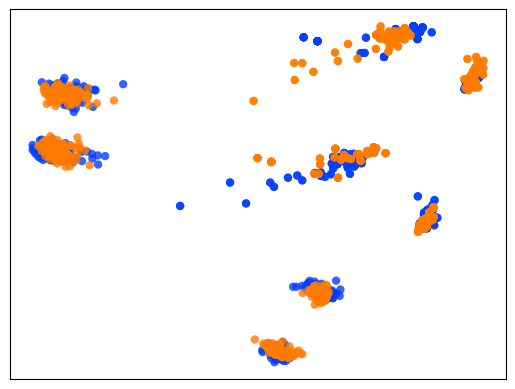

MSE: 1.67239
EMD: 553.09924
BaseEMD: -0.0

Layer: 11
Natty PCA


KeyboardInterrupt: 

In [157]:
from divergence_utils import visualize_states

max_diff = 0
pos = None
for layer in range(9,14): #range(all_modified_attribute_hidden_states_matrix.shape[1]):
    natty_hstates = torch.concat([
        all_modified_attribute_hidden_states_matrix[:200],
        all_modified_entity_hidden_states_matrix[:200],
    ], dim=0)[::2]
    intrv_hstates = torch.concat([
        all_intervened_attribute_hidden_states_matrix[:200],
        all_intervened_entity_hidden_states_matrix[:200],
    ], dim=0)[::2]
    
    natty_states, intrv_states = filter_by_layer_and_position(
        natty_hstates, intrv_hstates, layer=layer, pos=pos
    )
    print()
    print("Layer:", layer)
    diffs = visualize_states(
        natty_states,
        intrv_states,
        xdim=0,
        ydim=1,
        save_name=None,
        expl_var_threshold=0,
        sample_size=None,
    )
    mse = diffs["mse"]
    emd = diffs["emd"]
    base_emd = diffs["base_emd"]
    print("MSE:", mse)
    print("EMD:", emd)
    print("BaseEMD:", base_emd)
    
    diff = emd
    if diff>max_diff:
        max_layer = layer
        max_diff = diff
print("Max Diff Layer:", max_layer) 

Natty PCA


/tmp/ipykernel_3198279/4192547768.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_vecs = torch.tensor(vecs[:len(natty_states)])
/tmp/ipykernel_3198279/4192547768.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  intrv_vecs = torch.tensor(vecs[len(natty_states):])
/tmp/ipykernel_3198279/4192547768.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float()
/tmp/ipykernel_3198279/1042964669.py:42: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.


natty: torch.Size([25600, 4096])
intrv: torch.Size([25600, 4096])
Top Expl Vars: tensor([0.1207, 0.0923, 0.0682, 0.0519, 0.0479])
X: 0 Y: 1
Expl Vars: tensor(0.1207) tensor(0.0923)
Saved to all_states_all_positions.png


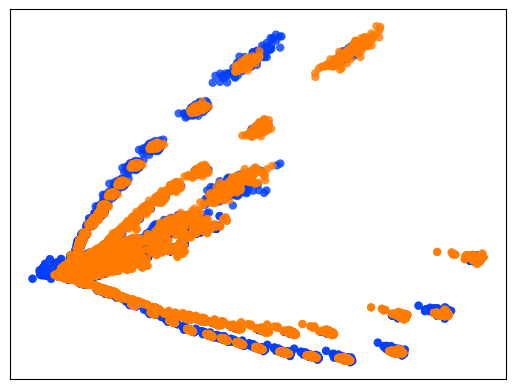

MSE: 1.17386
EMD: 409.4079
BaseEMD: 0.0


In [152]:
pos = None # None means all
layer = None # None means all

natty_hstates = torch.concat([
    all_modified_attribute_hidden_states_matrix[:200],
    all_modified_entity_hidden_states_matrix[:200],
], dim=0)[::2]
intrv_hstates = torch.concat([
    all_intervened_attribute_hidden_states_matrix[:200],
    all_intervened_entity_hidden_states_matrix[:200],
], dim=0)[::2]

natty_states, intrv_states = filter_by_layer_and_position(
    natty_hstates, intrv_hstates, layer=layer, pos=pos
)

diffs = visualize_states(
    natty_states,
    intrv_states,
    xdim=0,
    ydim=1,
    save_name="all_states_all_positions.png",
    expl_var_threshold=0,
    sample_size=None,
)
mse = diffs["mse"]
emd = diffs["emd"]
base_emd = diffs["base_emd"]
print("MSE:", mse)
print("EMD:", emd)
print("BaseEMD:", base_emd)
df = pd.DataFrame({
    "condition": ["Mean Diff"],
    "emd": [emd],
    "base_emd": [base_emd],
})
df.to_csv("mean_diff.csv", header=True, index=False)


In [153]:
df

,condition,emd,base_emd
0,Mean Diff,409.4079,0.0
